<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA6_Phase1/blob/main/EVA6_S7_Dilated_Albumentation_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jun 24 14:08:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Mounting the drive and copying the code from github to drive
'''
from google.colab import drive 
drive.mount('/content/gdrive')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA6_Phase1

In [ ]:
%cd Deep_Learning_EVA6_Phase1/src
! ls

In [2]:
!pip install albumentations==1.0.0

     |████████████████████████████████| 102kB 5.9MB/s 
     |████████████████████████████████| 38.2MB 77kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
cuda = torch.cuda.is_available()
print(f'Albumentations Version : {A.__version__}, Pytorch Version : {torch.__version__}, cuda:{cuda}')

Albumentations Version : 1.0.0, Pytorch Version : 1.9.0+cu102, cuda:True


In [ ]:
train = datasets.CIFAR10('./data', train=True, download=True)

n  = 0
s  = np.zeros(3)
sq = np.zeros(3)
i  = 0
batchsize = 128
for data, l in train:
  x   = np.array(data)/255                             # Image Normalization 
  s  += x.sum(axis=(0,1))                              # Summing up x & y values across 3 channels - CIFAR 10 size is 32,32,3. Useful for mean 
  sq += np.sum(np.square(x), axis=(0,1))               # Summing up x^2 and y^2 values across 3 channels. Useful for std dev calculation
  n  += x.shape[0]*x.shape[1]                          # Summing up no: of pixels.Each channel has 32x32. Final pixels per channel = # images * 32 *32
  i  += 1

batches = int(i/batchsize)
mu = s/n                               # mean = sum of pixel values/ no: of pixel values. Will return 3 element array as CIFAR10 has 3 channels
std = np.sqrt((sq/n - np.square(mu)))  # std dev = sqrt[sigma{x(i) - mean}^2/N]. Will return 3 element array as CIFAR10 has 3 channels
print(f'No: Of Train Images: {i}, Batch_size : {batchsize}, No: Of Batches:{batches}')
print(f'Channels Mean:{mu}, Channels Stdev:{std}, Total No: of pixels:{n}')


Extracting ./data/cifar-10-python.tar.gz to ./data
No: Of Train Images: 50000, Batch_size : 128, No: Of Batches:390
Channels Mean:[0.49139968 0.48215841 0.44653091], Channels Stdev:[0.24703223 0.24348513 0.26158784], Total No: of pixels:51200000


In [4]:
class Albumentations_transform:
  """
  Class to create test and train transforms using Albumentations. ToTensor() will be appended at the end of transforms list
  """
  def __init__(self, transforms_list=[]):
      self.transforms = A.Compose(transforms_list)

  """
  Library works only with named arguments and numpy array. Hence to make it compatible with torchvision, using wrapper to convert to np array
  """
  def __call__(self, img):
      img = np.array(img)
      img = self.transforms(image=img)['image']  # if ['image'] is not given, then it will give key error in dataloader
      img = np.transpose(img, (2,0,1))
      return img  

In [5]:
if cuda:
    torch.cuda.manual_seed(1)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

channels_mean  = [0.49139968, 0.48215841, 0.44653091]
channels_stdev = [0.24703223, 0.24348513, 0.26158784]

test_transforms   = Albumentations_transform([A.Normalize(mean=channels_mean, std=channels_stdev),])
train_transforms  = Albumentations_transform([A.HorizontalFlip(),
                                              A.ShiftScaleRotate(),
                                              A.ToGray(),
                                              A.Normalize(mean=channels_mean, std=channels_stdev),
                                              A.CoarseDropout(max_holes=1, max_height=16, max_width=16,min_holes=1,
                                                              min_height=16,min_width=16,fill_value=channels_mean,mask_fill_value=None),
                                              ])

train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

# train dataloader
trainloader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(test_data, **dataloader_args)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# Function to unnormalize and bring back to original pixel values. Transpose is to reshape the image on x & y axes and make it ready for display
def unnormalize(img):
    for i in range(img.shape[0]):
        img[i] = (img[i]*channels_stdev[i])+channels_mean[i]
    img = img.permute(1, 2, 0)
    return img

images.shape:torch.Size([128, 3, 32, 32]), labels.shape:torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


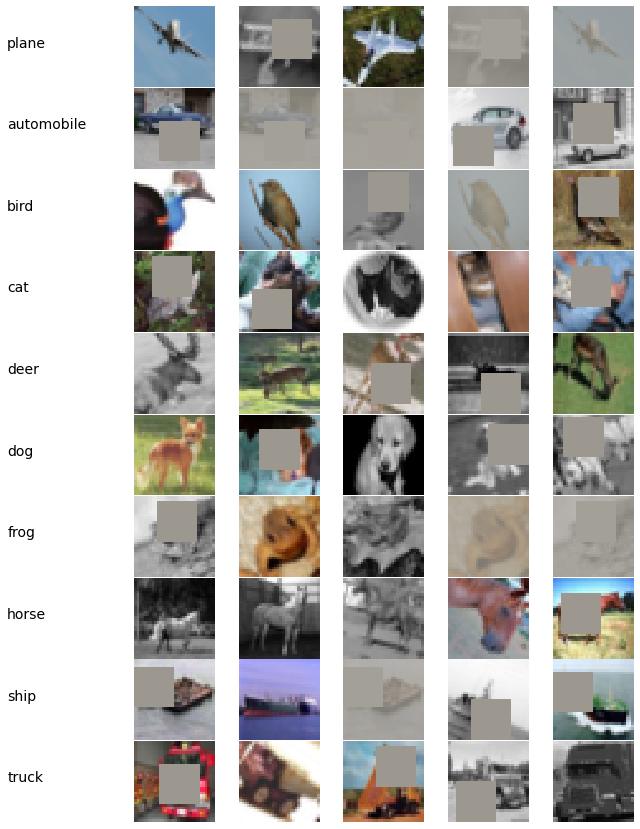

In [7]:
dataiter       = iter(trainloader)
images, labels = dataiter.next()
num_classes    = 10
print(f'images.shape:{images.shape}, labels.shape:{labels.shape}')
# display 5 images from each category. 
class_names = ['plane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

row, col   = 10, 8
num_images = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for class_num in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==class_num)[0], num_images)  ## Selecting 5 random images for each class
    ax  = plt.subplot(row, col,class_num*col + 1)                          ## Laying out space for display of a particular class
    ax.text(-0.1, 0.5, class_names[class_num], fontsize=14)                ## Displaying class names
    plt.axis('off')
    for j in range(1, num_images+1):                                       ## Displaying images one-by-one for a particular class
        plt.subplot(row, col, class_num*col+j+1)
        #img = images[idx[j-1]].permute(2,0,1)   # Changing image shape from 32(H), 32(w), 3 --> 3, 32(H), 32(W). If not done, images will come out too bright
        img = images[idx[j-1]]
        plt.imshow(unnormalize(img), interpolation='none')
        plt.axis('off')
plt.show()

In [14]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

       # CONVOLUTION BLOCK 0
        self.convblock0A = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        ) # in = 32x32x3 , out = 32x32x32, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock1A = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        ) # in = 32x32x3 , out = 32x32x32, RF = 3

        self.depthwise1A = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, groups=32),
            nn.ReLU(),
            nn.BatchNorm2d(64), 
        ) # in = 32x32x3 * 3x3x3 , out = 32x32x1x32, RF = 5
        self.pointwise1A = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 32x32x1X32 , out = 32x32x64, RF = 5

        self.depthwise1B = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, groups=32),
            nn.ReLU(),
            nn.BatchNorm2d(64), 
        ) # in = 32x32x64 , out = 32x32x64, RF = 7
        self.pointwise1B = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 32x32x1X64 , out = 32x32x64, RF = 7

        self.depthwise1C = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, groups=32),
            nn.ReLU(),
            nn.BatchNorm2d(64), 
        ) # in = 32x32x64 , out = 32x32x64, RF = 9
        self.pointwise1C = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 32x32x1X64 , out = 32x32x32   , RF = 9            

        # TRANSITION BLOCK 1
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        ) # in = 32x32x32 , out = 28x28x32  , RF = 13                          
   
        # CONVOLUTION BLOCK 2

        self.convblock2A = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        ) # in = 24x24x32 , out = 20x20x32, RF = 15

        self.depthwise2A = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False, groups=32),
            nn.ReLU(),
            nn.BatchNorm2d(32), 
        ) # in = 28x28x32 * 3x3x3 , out = 28x28x1x32, RF = 17
        self.pointwise2A = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 28x28x1X32 , out = 28x28x64    , RF = 17 

        self.depthwise2B = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, groups=64),
            nn.ReLU(),
            nn.BatchNorm2d(64), 
        ) # in = 28x28x1x64 , out = 28x28x64, RF = 19
        self.pointwise2B = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 28x28x64 , out = 28x28x64 , RF = 19

        self.depthwise2C = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, groups=64),
            nn.ReLU(),
            nn.BatchNorm2d(64), 
        ) # in = 28x28x1x64 , out = 28x28x64, RF = 21
        self.pointwise2C = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 28x28x64 , out = 28x28x32  , RF = 21       

        # TRANSITION BLOCK 2
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        ) # in = 28x28x32 , out = 24x24x32  , RF = 25                                                      
    

        # CONVOLUTION BLOCK 3        
        self.convblock3A = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        ) # in = 24x24x32 , out = 20x20x32, RF = 27

        self.depthwise3A = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False, groups=32),
            nn.ReLU(),
            nn.BatchNorm2d(32), 
        ) # in = 20x20x32 * 3x3x3 , out = 20x20x1x32, RF = 29
        self.pointwise3A = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 20x20x1X32 , out = 20x20x64, RF = 29

        self.depthwise3B = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, groups=32),
            nn.ReLU(),
            nn.BatchNorm2d(64), 
        ) # in = 20x20x1x64 , out = 20x20x64, RF = 31
        self.pointwise3B = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 20x20x64 , out = 20x20x64 , RF = 31

        self.depthwise3C = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, groups=32),
            nn.ReLU(),
            nn.BatchNorm2d(64), 
        ) # in = 20x20x1x64 , out = 20x20x64, RF = 33
        self.pointwise3C = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 20x20x64 , out = 20x20x32      , RF = 33         
                     
        # TRANSITION BLOCK 3
        self.pool3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=2,
                               padding=1, bias=False)   # in = 20x20x32 , out = 10x10x32, RF = 35

        # CONVOLUTION BLOCK 4        
        self.convblock4A = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        ) # in = 10X10x32 , out = 8X8x32, RF = 26, RF = 39

        self.convblock4B = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        ) # in = 8X8x32 , out =6x6x16, RF = 26   , RF = 43

        self.dilated5A = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=2, bias=False, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        ) # in = 6x6x16 , out = 6x6x16, RF = 7        , RF = 51
        
        # OUTPUT BLOCK
        self.Gap1 = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # in = 6x6x32 , out = 1x1x32, RF = 54	, RF = 61
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 1x1x32 , out = 1x1x10, RF = 54, RF = 61

    def forward(self, x):
        x = self.convblock0A(x)
        #x = self.pointwise1A(self.depthwise1A(self.convblock1A(x)))
        x = self.depthwise1A(self.convblock1A(x))
        #x = self.pointwise1B(self.depthwise1B(x))
        x = self.depthwise1B(x)
        x = self.pointwise1C(self.depthwise1C(x))        
        x = self.pool1(x)
        x = self.pointwise2A(self.depthwise2A(self.convblock2A(x)))
        #x = self.pointwise2B(self.depthwise2B(x))
        x = self.depthwise2B(x)
        x = self.pointwise2C(self.depthwise2C(x))         
        x = self.pool2(x)
        x = self.pointwise3A(self.depthwise3A(self.convblock3A(x)))
        #x = self.pointwise3B(self.depthwise3B(x))
        x = self.depthwise3B(x)
        x = self.pointwise3C(self.depthwise3C(x))        
        x = self.pool3(x)
        x = self.convblock4B(self.convblock4A(x))
        x = self.dilated5A(x)
        x = self.fc1(self.Gap1(x))
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [9]:
!pip install torchsummary
from torchsummary import summary

In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 32, 32]          18,432
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]           1,152
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]           1,152
             ReLU-11           [-1, 64, 32, 32]               0
      BatchNorm2d-12           [-1, 64, 32, 32]             128
           Conv2d-13           [-1, 64, 32, 32]           1,152
             ReLU-14           [-1

In [ ]:
print(model)

Net(
  (convblock1A): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwise1A): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pointwise1A): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (depthwise1B): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pointwise1B): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (depthwise1C): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [16]:
class train_losses():
    def __init__(self, model, device, train_loader, train_stats, optimizer, total_epochs):
        self.model = model
        self.device = device
        self.train_loader = train_loader
        self.stats = train_stats
        self.optimizer = optimizer
        self.total_epochs = total_epochs

    def s6_train(self, current_epoch, L1_factor=0):
        self.model.train()
        pbar = tqdm(self.train_loader)
        train_loss, correct, processed = 0, 0, 0
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            y_pred = self.model(data)
            train_loss = F.nll_loss(y_pred, target)

            # Updating train loss with L1 loss
            L1_Crit = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
            reg_loss = 0
            for param in self.model.parameters():
                zero_vector = torch.rand_like(param) * 0
                reg_loss += L1_Crit(param, zero_vector)
            train_loss += L1_factor * reg_loss

            train_loss.backward()
            self.optimizer.step()

            pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

            pbar.set_description(
                desc=f'Loss={train_loss.item()} Batch_id={batch_idx} Train Accuracy={100 * correct / processed:0.2f}')

            train_loss /= processed
            self.stats.append_loss(round(train_loss.item(), 6))

        train_acc = round((100. * correct / len(self.train_loader.dataset)), 2)
        self.stats.append_acc(train_acc)

        print(f'Train set: Epoch : {current_epoch}/{self.total_epochs} Average loss: {train_loss :.4f}, Train Accuracy: {train_acc}')

In [17]:
class test_losses():
  def __init__(self, model, device, test_loader, test_stats, total_epochs):
      self.model       = model
      self.device      = device
      self.test_loader = test_loader
      self.stats       = test_stats
      self.total_epochs = total_epochs

  def s6_test(self, current_epoch):
      self.model.eval()
      test_loss, correct, count_wrong = 0, 0, 0
      with torch.no_grad():
          for data, target in self.test_loader:
              data, target = data.to(self.device), target.to(self.device)
              output = self.model(data)
              test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              correct += pred.eq(target.view_as(pred)).sum().item()

              if current_epoch == (self.total_epochs - 1):
                  compare = pred.eq(target.view_as(pred))
                  misclass_idx = (compare == False).nonzero(as_tuple=True)[0].tolist()
                  for i in misclass_idx:
                      self.stats.append_img(data[i])
                      self.stats.append_pred(pred[i].item())
                      self.stats.append_label(target[i].item())

      test_loss /= len(self.test_loader.dataset)
      self.stats.append_loss(round(test_loss,6))
      test_acc = round((100. * correct / len(self.test_loader.dataset)), 2)
      self.stats.append_acc(test_acc)

      print(f'Test set: Epoch : {current_epoch}/{self.total_epochs} Average loss: {test_loss :.4f}, Test Accuracy: {test_acc}')

In [18]:
class stats_collector():
    def __init__(self):
        self.losses = []
        self.accuracy = []
        self.img = []
        self.pred = []
        self.label = []

    def append_loss(self, loss):
        self.losses.append(loss)

    def append_acc(self, acc):
        self.accuracy.append(acc)

    def append_img(self, image):
        self.img.append(image)

    def append_pred(self, pred):
        self.pred.append(pred)

    def append_label(self, label):
        self.label.append(label)

In [19]:
from torch.optim.lr_scheduler import OneCycleLR

In [20]:
EPOCHS = 200
#model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.8, weight_decay = 0)
SCHEDULER = OneCycleLR(optimizer, max_lr=0.2, steps_per_epoch=len(trainloader), epochs=EPOCHS)
train_stats, test_stats = stats_collector(), stats_collector()
train = train_losses(model, device, trainloader, train_stats, optimizer, EPOCHS)
test  = test_losses(model, device, testloader, test_stats, EPOCHS)

for epoch in range(EPOCHS):
    print(f'EPOCH: {epoch}')
    train.s6_train(epoch, L1_factor=0.0005)
    test.s6_test(epoch)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.8015754222869873 Batch_id=390 Train Accuracy=27.95: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]

Train set: Epoch : 0/200 Average loss: 0.0000, Train Accuracy: 27.95



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 0/200 Average loss: 1.5634, Test Accuracy: 40.84
EPOCH: 1


Loss=1.6278284788131714 Batch_id=390 Train Accuracy=39.16: 100%|██████████| 391/391 [00:27<00:00, 14.40it/s]

Train set: Epoch : 1/200 Average loss: 0.0000, Train Accuracy: 39.16



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 1/200 Average loss: 1.3412, Test Accuracy: 50.02
EPOCH: 2


Loss=1.6026087999343872 Batch_id=390 Train Accuracy=44.27: 100%|██████████| 391/391 [00:26<00:00, 14.53it/s]

Train set: Epoch : 2/200 Average loss: 0.0000, Train Accuracy: 44.27



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 2/200 Average loss: 1.2487, Test Accuracy: 54.32
EPOCH: 3


Loss=1.5482739210128784 Batch_id=390 Train Accuracy=47.42: 100%|██████████| 391/391 [00:26<00:00, 14.50it/s]

Train set: Epoch : 3/200 Average loss: 0.0000, Train Accuracy: 47.42



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 3/200 Average loss: 1.1254, Test Accuracy: 59.6
EPOCH: 4


Loss=1.480987310409546 Batch_id=390 Train Accuracy=50.08: 100%|██████████| 391/391 [00:26<00:00, 14.50it/s]

Train set: Epoch : 4/200 Average loss: 0.0000, Train Accuracy: 50.08



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 4/200 Average loss: 1.1003, Test Accuracy: 61.27
EPOCH: 5


Loss=1.2868635654449463 Batch_id=390 Train Accuracy=52.33: 100%|██████████| 391/391 [00:27<00:00, 14.46it/s]

Train set: Epoch : 5/200 Average loss: 0.0000, Train Accuracy: 52.33



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 5/200 Average loss: 1.0236, Test Accuracy: 63.06
EPOCH: 6


Loss=1.3198801279067993 Batch_id=390 Train Accuracy=54.10: 100%|██████████| 391/391 [00:26<00:00, 14.51it/s]

Train set: Epoch : 6/200 Average loss: 0.0000, Train Accuracy: 54.1



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 6/200 Average loss: 1.0390, Test Accuracy: 63.33
EPOCH: 7


Loss=1.3324790000915527 Batch_id=390 Train Accuracy=55.15: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]

Train set: Epoch : 7/200 Average loss: 0.0000, Train Accuracy: 55.15



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 7/200 Average loss: 0.9511, Test Accuracy: 66.44
EPOCH: 8


Loss=1.1553387641906738 Batch_id=390 Train Accuracy=56.34: 100%|██████████| 391/391 [00:26<00:00, 14.48it/s]

Train set: Epoch : 8/200 Average loss: 0.0000, Train Accuracy: 56.34



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 8/200 Average loss: 0.9238, Test Accuracy: 67.75
EPOCH: 9


Loss=1.0821198225021362 Batch_id=390 Train Accuracy=57.47: 100%|██████████| 391/391 [00:26<00:00, 14.52it/s]

Train set: Epoch : 9/200 Average loss: 0.0000, Train Accuracy: 57.47



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 9/200 Average loss: 0.8695, Test Accuracy: 69.6
EPOCH: 10


Loss=1.3476728200912476 Batch_id=390 Train Accuracy=58.37: 100%|██████████| 391/391 [00:27<00:00, 14.44it/s]

Train set: Epoch : 10/200 Average loss: 0.0000, Train Accuracy: 58.37



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 10/200 Average loss: 0.8708, Test Accuracy: 69.89
EPOCH: 11


Loss=1.369718074798584 Batch_id=390 Train Accuracy=58.81: 100%|██████████| 391/391 [00:27<00:00, 14.38it/s]

Train set: Epoch : 11/200 Average loss: 0.0000, Train Accuracy: 58.81



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 11/200 Average loss: 0.8485, Test Accuracy: 70.35
EPOCH: 12


Loss=1.2050994634628296 Batch_id=390 Train Accuracy=59.61: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]

Train set: Epoch : 12/200 Average loss: 0.0000, Train Accuracy: 59.61



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 12/200 Average loss: 0.8472, Test Accuracy: 70.48
EPOCH: 13


Loss=1.0370739698410034 Batch_id=390 Train Accuracy=60.30: 100%|██████████| 391/391 [00:27<00:00, 14.48it/s]

Train set: Epoch : 13/200 Average loss: 0.0000, Train Accuracy: 60.3



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 13/200 Average loss: 0.7891, Test Accuracy: 71.91
EPOCH: 14


Loss=1.195123553276062 Batch_id=390 Train Accuracy=61.20: 100%|██████████| 391/391 [00:26<00:00, 14.48it/s]

Train set: Epoch : 14/200 Average loss: 0.0000, Train Accuracy: 61.2



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 14/200 Average loss: 0.8046, Test Accuracy: 71.47
EPOCH: 15


Loss=1.0913188457489014 Batch_id=390 Train Accuracy=61.53: 100%|██████████| 391/391 [00:27<00:00, 14.43it/s]

Train set: Epoch : 15/200 Average loss: 0.0000, Train Accuracy: 61.53



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 15/200 Average loss: 0.7857, Test Accuracy: 72.85
EPOCH: 16


Loss=0.9470987915992737 Batch_id=390 Train Accuracy=62.23: 100%|██████████| 391/391 [00:27<00:00, 14.46it/s]

Train set: Epoch : 16/200 Average loss: 0.0000, Train Accuracy: 62.23



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 16/200 Average loss: 0.7735, Test Accuracy: 72.86
EPOCH: 17


Loss=0.8659356832504272 Batch_id=390 Train Accuracy=62.60: 100%|██████████| 391/391 [00:27<00:00, 14.44it/s]

Train set: Epoch : 17/200 Average loss: 0.0000, Train Accuracy: 62.6



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 17/200 Average loss: 0.7472, Test Accuracy: 74.07
EPOCH: 18


Loss=1.180846929550171 Batch_id=390 Train Accuracy=62.63: 100%|██████████| 391/391 [00:26<00:00, 14.50it/s]

Train set: Epoch : 18/200 Average loss: 0.0000, Train Accuracy: 62.63



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 18/200 Average loss: 0.7399, Test Accuracy: 74.42
EPOCH: 19


Loss=1.1421313285827637 Batch_id=390 Train Accuracy=62.81: 100%|██████████| 391/391 [00:27<00:00, 14.42it/s]

Train set: Epoch : 19/200 Average loss: 0.0000, Train Accuracy: 62.81



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 19/200 Average loss: 0.7537, Test Accuracy: 74.05
EPOCH: 20


Loss=1.1965062618255615 Batch_id=390 Train Accuracy=63.43: 100%|██████████| 391/391 [00:27<00:00, 14.42it/s]

Train set: Epoch : 20/200 Average loss: 0.0000, Train Accuracy: 63.43



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 20/200 Average loss: 0.7329, Test Accuracy: 74.41
EPOCH: 21


Loss=1.0548969507217407 Batch_id=390 Train Accuracy=63.92: 100%|██████████| 391/391 [00:26<00:00, 14.50it/s]

Train set: Epoch : 21/200 Average loss: 0.0000, Train Accuracy: 63.92



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 21/200 Average loss: 0.7344, Test Accuracy: 74.41
EPOCH: 22


Loss=1.3179619312286377 Batch_id=390 Train Accuracy=64.04: 100%|██████████| 391/391 [00:27<00:00, 14.45it/s]

Train set: Epoch : 22/200 Average loss: 0.0000, Train Accuracy: 64.04



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 22/200 Average loss: 0.7376, Test Accuracy: 74.19
EPOCH: 23


Loss=0.9178109169006348 Batch_id=390 Train Accuracy=64.62: 100%|██████████| 391/391 [00:27<00:00, 14.33it/s]

Train set: Epoch : 23/200 Average loss: 0.0000, Train Accuracy: 64.62



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 23/200 Average loss: 0.7166, Test Accuracy: 75.7
EPOCH: 24


Loss=1.1395318508148193 Batch_id=390 Train Accuracy=64.89: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]

Train set: Epoch : 24/200 Average loss: 0.0000, Train Accuracy: 64.89



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 24/200 Average loss: 0.6994, Test Accuracy: 75.81
EPOCH: 25


Loss=1.0161151885986328 Batch_id=390 Train Accuracy=65.41: 100%|██████████| 391/391 [00:27<00:00, 14.40it/s]

Train set: Epoch : 25/200 Average loss: 0.0000, Train Accuracy: 65.41



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 25/200 Average loss: 0.6975, Test Accuracy: 75.79
EPOCH: 26


Loss=1.0800731182098389 Batch_id=390 Train Accuracy=65.49: 100%|██████████| 391/391 [00:27<00:00, 14.41it/s]

Train set: Epoch : 26/200 Average loss: 0.0000, Train Accuracy: 65.49



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 26/200 Average loss: 0.6851, Test Accuracy: 76.31
EPOCH: 27


Loss=0.8982294797897339 Batch_id=390 Train Accuracy=65.80: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]

Train set: Epoch : 27/200 Average loss: 0.0000, Train Accuracy: 65.8



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 27/200 Average loss: 0.6869, Test Accuracy: 76.03
EPOCH: 28


Loss=0.7689913511276245 Batch_id=390 Train Accuracy=65.94: 100%|██████████| 391/391 [00:27<00:00, 14.35it/s]

Train set: Epoch : 28/200 Average loss: 0.0000, Train Accuracy: 65.94



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 28/200 Average loss: 0.6819, Test Accuracy: 76.55
EPOCH: 29


Loss=0.7727620005607605 Batch_id=390 Train Accuracy=66.51: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]

Train set: Epoch : 29/200 Average loss: 0.0000, Train Accuracy: 66.51



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 29/200 Average loss: 0.6784, Test Accuracy: 76.76
EPOCH: 30


Loss=0.9380818605422974 Batch_id=390 Train Accuracy=66.52: 100%|██████████| 391/391 [00:27<00:00, 14.42it/s]

Train set: Epoch : 30/200 Average loss: 0.0000, Train Accuracy: 66.52



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 30/200 Average loss: 0.6533, Test Accuracy: 77.3
EPOCH: 31


Loss=1.0300986766815186 Batch_id=390 Train Accuracy=66.62: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s]

Train set: Epoch : 31/200 Average loss: 0.0000, Train Accuracy: 66.62



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 31/200 Average loss: 0.6656, Test Accuracy: 77.22
EPOCH: 32


Loss=1.0509026050567627 Batch_id=390 Train Accuracy=66.45: 100%|██████████| 391/391 [00:27<00:00, 14.44it/s]

Train set: Epoch : 32/200 Average loss: 0.0000, Train Accuracy: 66.45



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 32/200 Average loss: 0.6467, Test Accuracy: 77.36
EPOCH: 33


Loss=1.0208786725997925 Batch_id=390 Train Accuracy=66.97: 100%|██████████| 391/391 [00:27<00:00, 14.42it/s]

Train set: Epoch : 33/200 Average loss: 0.0000, Train Accuracy: 66.97



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 33/200 Average loss: 0.6703, Test Accuracy: 77.07
EPOCH: 34


Loss=0.9015843272209167 Batch_id=390 Train Accuracy=66.95: 100%|██████████| 391/391 [00:27<00:00, 14.34it/s]

Train set: Epoch : 34/200 Average loss: 0.0000, Train Accuracy: 66.95



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 34/200 Average loss: 0.6254, Test Accuracy: 78.45
EPOCH: 35


Loss=0.909392774105072 Batch_id=390 Train Accuracy=67.33: 100%|██████████| 391/391 [00:27<00:00, 14.35it/s]

Train set: Epoch : 35/200 Average loss: 0.0000, Train Accuracy: 67.33



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 35/200 Average loss: 0.6339, Test Accuracy: 77.62
EPOCH: 36


Loss=1.0863538980484009 Batch_id=390 Train Accuracy=67.75: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]

Train set: Epoch : 36/200 Average loss: 0.0000, Train Accuracy: 67.75



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 36/200 Average loss: 0.6278, Test Accuracy: 78.3
EPOCH: 37


Loss=0.8836206197738647 Batch_id=390 Train Accuracy=68.11: 100%|██████████| 391/391 [00:27<00:00, 14.44it/s]

Train set: Epoch : 37/200 Average loss: 0.0000, Train Accuracy: 68.11



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 37/200 Average loss: 0.6224, Test Accuracy: 78.39
EPOCH: 38


Loss=1.016125202178955 Batch_id=390 Train Accuracy=67.84: 100%|██████████| 391/391 [00:27<00:00, 14.44it/s]

Train set: Epoch : 38/200 Average loss: 0.0000, Train Accuracy: 67.84



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 38/200 Average loss: 0.6273, Test Accuracy: 77.95
EPOCH: 39


Loss=1.1722266674041748 Batch_id=390 Train Accuracy=68.52: 100%|██████████| 391/391 [00:27<00:00, 14.40it/s]

Train set: Epoch : 39/200 Average loss: 0.0000, Train Accuracy: 68.52



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 39/200 Average loss: 0.6064, Test Accuracy: 78.7
EPOCH: 40


Loss=0.8832035660743713 Batch_id=390 Train Accuracy=68.48: 100%|██████████| 391/391 [00:27<00:00, 14.45it/s]

Train set: Epoch : 40/200 Average loss: 0.0000, Train Accuracy: 68.48



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 40/200 Average loss: 0.6085, Test Accuracy: 78.56
EPOCH: 41


Loss=0.9106919765472412 Batch_id=390 Train Accuracy=68.64: 100%|██████████| 391/391 [00:27<00:00, 14.38it/s]

Train set: Epoch : 41/200 Average loss: 0.0000, Train Accuracy: 68.64



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 41/200 Average loss: 0.5994, Test Accuracy: 79.07
EPOCH: 42


Loss=0.7254137396812439 Batch_id=390 Train Accuracy=68.62: 100%|██████████| 391/391 [00:27<00:00, 14.43it/s]

Train set: Epoch : 42/200 Average loss: 0.0000, Train Accuracy: 68.62



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 42/200 Average loss: 0.6114, Test Accuracy: 78.81
EPOCH: 43


Loss=0.7124547958374023 Batch_id=390 Train Accuracy=68.98: 100%|██████████| 391/391 [00:27<00:00, 14.42it/s]

Train set: Epoch : 43/200 Average loss: 0.0000, Train Accuracy: 68.98



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 43/200 Average loss: 0.6009, Test Accuracy: 79.36
EPOCH: 44


Loss=0.8089547157287598 Batch_id=390 Train Accuracy=68.90: 100%|██████████| 391/391 [00:27<00:00, 14.42it/s]

Train set: Epoch : 44/200 Average loss: 0.0000, Train Accuracy: 68.9



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 44/200 Average loss: 0.6126, Test Accuracy: 78.44
EPOCH: 45


Loss=0.8324240446090698 Batch_id=390 Train Accuracy=69.09: 100%|██████████| 391/391 [00:27<00:00, 14.42it/s]

Train set: Epoch : 45/200 Average loss: 0.0000, Train Accuracy: 69.09



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 45/200 Average loss: 0.6084, Test Accuracy: 78.78
EPOCH: 46


Loss=1.0171176195144653 Batch_id=390 Train Accuracy=69.59: 100%|██████████| 391/391 [00:27<00:00, 14.46it/s]

Train set: Epoch : 46/200 Average loss: 0.0000, Train Accuracy: 69.59



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 46/200 Average loss: 0.5998, Test Accuracy: 79.24
EPOCH: 47


Loss=0.6938430070877075 Batch_id=390 Train Accuracy=69.44: 100%|██████████| 391/391 [00:27<00:00, 14.37it/s]

Train set: Epoch : 47/200 Average loss: 0.0000, Train Accuracy: 69.44



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 47/200 Average loss: 0.5779, Test Accuracy: 79.7
EPOCH: 48


Loss=0.9033679366111755 Batch_id=390 Train Accuracy=69.58: 100%|██████████| 391/391 [00:26<00:00, 14.49it/s]

Train set: Epoch : 48/200 Average loss: 0.0000, Train Accuracy: 69.58



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 48/200 Average loss: 0.5935, Test Accuracy: 79.7
EPOCH: 49


Loss=0.8297648429870605 Batch_id=390 Train Accuracy=69.71: 100%|██████████| 391/391 [00:27<00:00, 14.31it/s]

Train set: Epoch : 49/200 Average loss: 0.0000, Train Accuracy: 69.71



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 49/200 Average loss: 0.5893, Test Accuracy: 79.91
EPOCH: 50


Loss=0.787076473236084 Batch_id=390 Train Accuracy=69.84: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]

Train set: Epoch : 50/200 Average loss: 0.0000, Train Accuracy: 69.84



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 50/200 Average loss: 0.5860, Test Accuracy: 79.78
EPOCH: 51


Loss=0.7697761654853821 Batch_id=390 Train Accuracy=70.39: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]

Train set: Epoch : 51/200 Average loss: 0.0000, Train Accuracy: 70.39



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 51/200 Average loss: 0.5863, Test Accuracy: 79.48
EPOCH: 52


Loss=1.0693285465240479 Batch_id=390 Train Accuracy=70.37: 100%|██████████| 391/391 [00:27<00:00, 14.39it/s]

Train set: Epoch : 52/200 Average loss: 0.0000, Train Accuracy: 70.37



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 52/200 Average loss: 0.5632, Test Accuracy: 80.45
EPOCH: 53


Loss=1.0197075605392456 Batch_id=390 Train Accuracy=70.45: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s]

Train set: Epoch : 53/200 Average loss: 0.0000, Train Accuracy: 70.45



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 53/200 Average loss: 0.5692, Test Accuracy: 79.99
EPOCH: 54


Loss=0.9698653817176819 Batch_id=390 Train Accuracy=70.39: 100%|██████████| 391/391 [00:27<00:00, 14.33it/s]

Train set: Epoch : 54/200 Average loss: 0.0000, Train Accuracy: 70.39



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 54/200 Average loss: 0.5790, Test Accuracy: 80.11
EPOCH: 55


Loss=0.7897462844848633 Batch_id=390 Train Accuracy=70.65: 100%|██████████| 391/391 [00:27<00:00, 14.30it/s]

Train set: Epoch : 55/200 Average loss: 0.0000, Train Accuracy: 70.65



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 55/200 Average loss: 0.5598, Test Accuracy: 80.26
EPOCH: 56


Loss=0.8100588321685791 Batch_id=390 Train Accuracy=70.90: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 56/200 Average loss: 0.0000, Train Accuracy: 70.9



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 56/200 Average loss: 0.5511, Test Accuracy: 80.88
EPOCH: 57


Loss=0.7978195548057556 Batch_id=390 Train Accuracy=70.94: 100%|██████████| 391/391 [00:27<00:00, 14.30it/s]

Train set: Epoch : 57/200 Average loss: 0.0000, Train Accuracy: 70.94



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 57/200 Average loss: 0.5729, Test Accuracy: 80.05
EPOCH: 58


Loss=0.9857110977172852 Batch_id=390 Train Accuracy=70.77: 100%|██████████| 391/391 [00:27<00:00, 14.31it/s]

Train set: Epoch : 58/200 Average loss: 0.0000, Train Accuracy: 70.77



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 58/200 Average loss: 0.5724, Test Accuracy: 79.99
EPOCH: 59


Loss=0.7870489358901978 Batch_id=390 Train Accuracy=71.18: 100%|██████████| 391/391 [00:27<00:00, 14.24it/s]

Train set: Epoch : 59/200 Average loss: 0.0000, Train Accuracy: 71.18



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 59/200 Average loss: 0.5483, Test Accuracy: 81.47
EPOCH: 60


Loss=0.856671929359436 Batch_id=390 Train Accuracy=71.20: 100%|██████████| 391/391 [00:27<00:00, 14.29it/s]

Train set: Epoch : 60/200 Average loss: 0.0000, Train Accuracy: 71.2



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 60/200 Average loss: 0.5637, Test Accuracy: 80.59
EPOCH: 61


Loss=0.870701014995575 Batch_id=390 Train Accuracy=71.01: 100%|██████████| 391/391 [00:27<00:00, 14.30it/s]

Train set: Epoch : 61/200 Average loss: 0.0000, Train Accuracy: 71.01



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 61/200 Average loss: 0.5428, Test Accuracy: 81.61
EPOCH: 62


Loss=0.7687966227531433 Batch_id=390 Train Accuracy=71.27: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 62/200 Average loss: 0.0000, Train Accuracy: 71.27



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 62/200 Average loss: 0.5475, Test Accuracy: 81.11
EPOCH: 63


Loss=0.9158913493156433 Batch_id=390 Train Accuracy=70.95: 100%|██████████| 391/391 [00:27<00:00, 14.24it/s]

Train set: Epoch : 63/200 Average loss: 0.0000, Train Accuracy: 70.95



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 63/200 Average loss: 0.5423, Test Accuracy: 81.08
EPOCH: 64


Loss=0.6900501847267151 Batch_id=390 Train Accuracy=71.33: 100%|██████████| 391/391 [00:27<00:00, 14.28it/s]

Train set: Epoch : 64/200 Average loss: 0.0000, Train Accuracy: 71.33



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 64/200 Average loss: 0.5521, Test Accuracy: 80.92
EPOCH: 65


Loss=0.867079496383667 Batch_id=390 Train Accuracy=71.50: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]

Train set: Epoch : 65/200 Average loss: 0.0000, Train Accuracy: 71.5



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 65/200 Average loss: 0.5398, Test Accuracy: 81.07
EPOCH: 66


Loss=1.0540244579315186 Batch_id=390 Train Accuracy=71.69: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 66/200 Average loss: 0.0000, Train Accuracy: 71.69



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 66/200 Average loss: 0.5311, Test Accuracy: 81.67
EPOCH: 67


Loss=0.7398741841316223 Batch_id=390 Train Accuracy=71.70: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s]

Train set: Epoch : 67/200 Average loss: 0.0000, Train Accuracy: 71.7



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 67/200 Average loss: 0.5478, Test Accuracy: 80.71
EPOCH: 68


Loss=0.7043368816375732 Batch_id=390 Train Accuracy=71.74: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 68/200 Average loss: 0.0000, Train Accuracy: 71.74



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 68/200 Average loss: 0.5404, Test Accuracy: 81.21
EPOCH: 69


Loss=0.7369908094406128 Batch_id=390 Train Accuracy=71.91: 100%|██████████| 391/391 [00:27<00:00, 14.25it/s]

Train set: Epoch : 69/200 Average loss: 0.0000, Train Accuracy: 71.91



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 69/200 Average loss: 0.5376, Test Accuracy: 81.19
EPOCH: 70


Loss=0.9727019667625427 Batch_id=390 Train Accuracy=71.95: 100%|██████████| 391/391 [00:27<00:00, 14.12it/s]

Train set: Epoch : 70/200 Average loss: 0.0000, Train Accuracy: 71.95



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 70/200 Average loss: 0.5434, Test Accuracy: 81.19
EPOCH: 71


Loss=0.8910492062568665 Batch_id=390 Train Accuracy=71.96: 100%|██████████| 391/391 [00:27<00:00, 14.25it/s]

Train set: Epoch : 71/200 Average loss: 0.0000, Train Accuracy: 71.96



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 71/200 Average loss: 0.5327, Test Accuracy: 81.48
EPOCH: 72


Loss=0.8846091628074646 Batch_id=390 Train Accuracy=72.18: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]

Train set: Epoch : 72/200 Average loss: 0.0000, Train Accuracy: 72.18



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 72/200 Average loss: 0.5278, Test Accuracy: 81.96
EPOCH: 73


Loss=0.7785409688949585 Batch_id=390 Train Accuracy=72.23: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 73/200 Average loss: 0.0000, Train Accuracy: 72.23



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 73/200 Average loss: 0.5298, Test Accuracy: 81.64
EPOCH: 74


Loss=0.7999377250671387 Batch_id=390 Train Accuracy=72.21: 100%|██████████| 391/391 [00:27<00:00, 14.08it/s]

Train set: Epoch : 74/200 Average loss: 0.0000, Train Accuracy: 72.21



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 74/200 Average loss: 0.5313, Test Accuracy: 81.72
EPOCH: 75


Loss=1.1175858974456787 Batch_id=390 Train Accuracy=72.06: 100%|██████████| 391/391 [00:27<00:00, 14.08it/s]

Train set: Epoch : 75/200 Average loss: 0.0000, Train Accuracy: 72.06



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 75/200 Average loss: 0.5332, Test Accuracy: 81.73
EPOCH: 76


Loss=0.7768879532814026 Batch_id=390 Train Accuracy=72.75: 100%|██████████| 391/391 [00:27<00:00, 13.97it/s]

Train set: Epoch : 76/200 Average loss: 0.0000, Train Accuracy: 72.75



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 76/200 Average loss: 0.5182, Test Accuracy: 81.9
EPOCH: 77


Loss=0.6309540867805481 Batch_id=390 Train Accuracy=72.69: 100%|██████████| 391/391 [00:27<00:00, 14.11it/s]

Train set: Epoch : 77/200 Average loss: 0.0000, Train Accuracy: 72.69



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 77/200 Average loss: 0.5380, Test Accuracy: 81.24
EPOCH: 78


Loss=0.9755229949951172 Batch_id=390 Train Accuracy=72.50: 100%|██████████| 391/391 [00:27<00:00, 13.97it/s]

Train set: Epoch : 78/200 Average loss: 0.0000, Train Accuracy: 72.5



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 78/200 Average loss: 0.5256, Test Accuracy: 81.83
EPOCH: 79


Loss=0.6385695338249207 Batch_id=390 Train Accuracy=72.63: 100%|██████████| 391/391 [00:27<00:00, 14.13it/s]

Train set: Epoch : 79/200 Average loss: 0.0000, Train Accuracy: 72.63



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 79/200 Average loss: 0.5259, Test Accuracy: 82.05
EPOCH: 80


Loss=0.8736523389816284 Batch_id=390 Train Accuracy=72.68: 100%|██████████| 391/391 [00:27<00:00, 14.04it/s]

Train set: Epoch : 80/200 Average loss: 0.0000, Train Accuracy: 72.68



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 80/200 Average loss: 0.5319, Test Accuracy: 81.91
EPOCH: 81


Loss=0.786415696144104 Batch_id=390 Train Accuracy=72.76: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]

Train set: Epoch : 81/200 Average loss: 0.0000, Train Accuracy: 72.76



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 81/200 Average loss: 0.5209, Test Accuracy: 82.49
EPOCH: 82


Loss=0.951055109500885 Batch_id=390 Train Accuracy=72.88: 100%|██████████| 391/391 [00:28<00:00, 13.95it/s]

Train set: Epoch : 82/200 Average loss: 0.0000, Train Accuracy: 72.88



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 82/200 Average loss: 0.5162, Test Accuracy: 82.17
EPOCH: 83


Loss=0.9224196076393127 Batch_id=390 Train Accuracy=73.25: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]

Train set: Epoch : 83/200 Average loss: 0.0000, Train Accuracy: 73.25



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 83/200 Average loss: 0.5197, Test Accuracy: 82.13
EPOCH: 84


Loss=0.9503985643386841 Batch_id=390 Train Accuracy=72.95: 100%|██████████| 391/391 [00:27<00:00, 14.00it/s]

Train set: Epoch : 84/200 Average loss: 0.0000, Train Accuracy: 72.95



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 84/200 Average loss: 0.5112, Test Accuracy: 82.51
EPOCH: 85


Loss=0.8494353294372559 Batch_id=390 Train Accuracy=73.03: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]

Train set: Epoch : 85/200 Average loss: 0.0000, Train Accuracy: 73.03



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 85/200 Average loss: 0.5176, Test Accuracy: 82.01
EPOCH: 86


Loss=0.7288137078285217 Batch_id=390 Train Accuracy=73.01: 100%|██████████| 391/391 [00:28<00:00, 13.93it/s]

Train set: Epoch : 86/200 Average loss: 0.0000, Train Accuracy: 73.01



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 86/200 Average loss: 0.5181, Test Accuracy: 82.21
EPOCH: 87


Loss=0.8068410754203796 Batch_id=390 Train Accuracy=73.40: 100%|██████████| 391/391 [00:27<00:00, 13.98it/s]

Train set: Epoch : 87/200 Average loss: 0.0000, Train Accuracy: 73.4



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 87/200 Average loss: 0.5079, Test Accuracy: 82.62
EPOCH: 88


Loss=0.696491003036499 Batch_id=390 Train Accuracy=73.22: 100%|██████████| 391/391 [00:27<00:00, 14.03it/s]

Train set: Epoch : 88/200 Average loss: 0.0000, Train Accuracy: 73.22



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 88/200 Average loss: 0.5032, Test Accuracy: 82.62
EPOCH: 89


Loss=0.8729190230369568 Batch_id=390 Train Accuracy=73.30: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]

Train set: Epoch : 89/200 Average loss: 0.0000, Train Accuracy: 73.3



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 89/200 Average loss: 0.5066, Test Accuracy: 82.34
EPOCH: 90


Loss=0.8723364472389221 Batch_id=390 Train Accuracy=72.99: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 90/200 Average loss: 0.0000, Train Accuracy: 72.99



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 90/200 Average loss: 0.5106, Test Accuracy: 82.65
EPOCH: 91


Loss=0.6757525205612183 Batch_id=390 Train Accuracy=73.20: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]

Train set: Epoch : 91/200 Average loss: 0.0000, Train Accuracy: 73.2



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 91/200 Average loss: 0.4968, Test Accuracy: 82.87
EPOCH: 92


Loss=0.8036445379257202 Batch_id=390 Train Accuracy=73.49: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 92/200 Average loss: 0.0000, Train Accuracy: 73.49



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 92/200 Average loss: 0.5086, Test Accuracy: 82.78
EPOCH: 93


Loss=0.597328782081604 Batch_id=390 Train Accuracy=73.27: 100%|██████████| 391/391 [00:27<00:00, 14.08it/s]

Train set: Epoch : 93/200 Average loss: 0.0000, Train Accuracy: 73.27



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 93/200 Average loss: 0.5012, Test Accuracy: 82.71
EPOCH: 94


Loss=0.6555801630020142 Batch_id=390 Train Accuracy=73.56: 100%|██████████| 391/391 [00:27<00:00, 14.03it/s]

Train set: Epoch : 94/200 Average loss: 0.0000, Train Accuracy: 73.56



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 94/200 Average loss: 0.5130, Test Accuracy: 82.81
EPOCH: 95


Loss=0.9268977046012878 Batch_id=390 Train Accuracy=73.45: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]

Train set: Epoch : 95/200 Average loss: 0.0000, Train Accuracy: 73.45



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 95/200 Average loss: 0.5089, Test Accuracy: 82.98
EPOCH: 96


Loss=0.7299183011054993 Batch_id=390 Train Accuracy=73.47: 100%|██████████| 391/391 [00:27<00:00, 14.13it/s]

Train set: Epoch : 96/200 Average loss: 0.0000, Train Accuracy: 73.47



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 96/200 Average loss: 0.4997, Test Accuracy: 82.74
EPOCH: 97


Loss=0.6056094765663147 Batch_id=390 Train Accuracy=73.67: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]

Train set: Epoch : 97/200 Average loss: 0.0000, Train Accuracy: 73.67



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 97/200 Average loss: 0.4927, Test Accuracy: 83.07
EPOCH: 98


Loss=0.6552379131317139 Batch_id=390 Train Accuracy=73.84: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 98/200 Average loss: 0.0000, Train Accuracy: 73.84



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 98/200 Average loss: 0.4877, Test Accuracy: 83.59
EPOCH: 99


Loss=0.965364933013916 Batch_id=390 Train Accuracy=73.74: 100%|██████████| 391/391 [00:27<00:00, 14.25it/s]

Train set: Epoch : 99/200 Average loss: 0.0000, Train Accuracy: 73.74



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 99/200 Average loss: 0.4878, Test Accuracy: 83.05
EPOCH: 100


Loss=0.6210677027702332 Batch_id=390 Train Accuracy=73.99: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]

Train set: Epoch : 100/200 Average loss: 0.0000, Train Accuracy: 73.99



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 100/200 Average loss: 0.4946, Test Accuracy: 83.19
EPOCH: 101


Loss=0.7982547879219055 Batch_id=390 Train Accuracy=73.85: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]

Train set: Epoch : 101/200 Average loss: 0.0000, Train Accuracy: 73.85



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 101/200 Average loss: 0.5005, Test Accuracy: 82.59
EPOCH: 102


Loss=0.7463920712471008 Batch_id=390 Train Accuracy=73.93: 100%|██████████| 391/391 [00:27<00:00, 14.13it/s]

Train set: Epoch : 102/200 Average loss: 0.0000, Train Accuracy: 73.93



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 102/200 Average loss: 0.4910, Test Accuracy: 82.96
EPOCH: 103


Loss=0.7960553765296936 Batch_id=390 Train Accuracy=74.20: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 103/200 Average loss: 0.0000, Train Accuracy: 74.2



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 103/200 Average loss: 0.4952, Test Accuracy: 83.08
EPOCH: 104


Loss=0.5057224035263062 Batch_id=390 Train Accuracy=73.93: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 104/200 Average loss: 0.0000, Train Accuracy: 73.93



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 104/200 Average loss: 0.4964, Test Accuracy: 82.89
EPOCH: 105


Loss=0.694403886795044 Batch_id=390 Train Accuracy=74.31: 100%|██████████| 391/391 [00:27<00:00, 14.25it/s]

Train set: Epoch : 105/200 Average loss: 0.0000, Train Accuracy: 74.31



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 105/200 Average loss: 0.4883, Test Accuracy: 83.36
EPOCH: 106


Loss=0.5542049407958984 Batch_id=390 Train Accuracy=74.19: 100%|██████████| 391/391 [00:27<00:00, 14.12it/s]

Train set: Epoch : 106/200 Average loss: 0.0000, Train Accuracy: 74.19



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 106/200 Average loss: 0.4895, Test Accuracy: 83.29
EPOCH: 107


Loss=0.7940642833709717 Batch_id=390 Train Accuracy=74.21: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 107/200 Average loss: 0.0000, Train Accuracy: 74.21



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 107/200 Average loss: 0.4940, Test Accuracy: 83.07
EPOCH: 108


Loss=0.7131136655807495 Batch_id=390 Train Accuracy=74.27: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 108/200 Average loss: 0.0000, Train Accuracy: 74.27



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 108/200 Average loss: 0.4810, Test Accuracy: 83.73
EPOCH: 109


Loss=0.7559200525283813 Batch_id=390 Train Accuracy=74.35: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]

Train set: Epoch : 109/200 Average loss: 0.0000, Train Accuracy: 74.35



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 109/200 Average loss: 0.4834, Test Accuracy: 83.51
EPOCH: 110


Loss=0.6153115034103394 Batch_id=390 Train Accuracy=74.24: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 110/200 Average loss: 0.0000, Train Accuracy: 74.24



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 110/200 Average loss: 0.4774, Test Accuracy: 83.7
EPOCH: 111


Loss=0.6433021426200867 Batch_id=390 Train Accuracy=74.34: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 111/200 Average loss: 0.0000, Train Accuracy: 74.34



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 111/200 Average loss: 0.4901, Test Accuracy: 83.47
EPOCH: 112


Loss=0.7067170143127441 Batch_id=390 Train Accuracy=74.29: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]

Train set: Epoch : 112/200 Average loss: 0.0000, Train Accuracy: 74.29



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 112/200 Average loss: 0.4851, Test Accuracy: 83.19
EPOCH: 113


Loss=0.9578953981399536 Batch_id=390 Train Accuracy=74.43: 100%|██████████| 391/391 [00:27<00:00, 14.12it/s]

Train set: Epoch : 113/200 Average loss: 0.0000, Train Accuracy: 74.43



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 113/200 Average loss: 0.4994, Test Accuracy: 83.17
EPOCH: 114


Loss=0.7153259515762329 Batch_id=390 Train Accuracy=74.55: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]

Train set: Epoch : 114/200 Average loss: 0.0000, Train Accuracy: 74.55



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 114/200 Average loss: 0.4804, Test Accuracy: 83.45
EPOCH: 115


Loss=0.7826898694038391 Batch_id=390 Train Accuracy=74.39: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 115/200 Average loss: 0.0000, Train Accuracy: 74.39



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 115/200 Average loss: 0.4793, Test Accuracy: 83.57
EPOCH: 116


Loss=0.5786411762237549 Batch_id=390 Train Accuracy=74.67: 100%|██████████| 391/391 [00:27<00:00, 13.97it/s]

Train set: Epoch : 116/200 Average loss: 0.0000, Train Accuracy: 74.67



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 116/200 Average loss: 0.4751, Test Accuracy: 83.46
EPOCH: 117


Loss=0.7959513664245605 Batch_id=390 Train Accuracy=74.78: 100%|██████████| 391/391 [00:28<00:00, 13.72it/s]

Train set: Epoch : 117/200 Average loss: 0.0000, Train Accuracy: 74.78



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 117/200 Average loss: 0.4802, Test Accuracy: 83.79
EPOCH: 118


Loss=0.9169684648513794 Batch_id=390 Train Accuracy=74.48: 100%|██████████| 391/391 [00:28<00:00, 13.74it/s]

Train set: Epoch : 118/200 Average loss: 0.0000, Train Accuracy: 74.48



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 118/200 Average loss: 0.4756, Test Accuracy: 83.75
EPOCH: 119


Loss=0.6064829230308533 Batch_id=390 Train Accuracy=74.80: 100%|██████████| 391/391 [00:27<00:00, 14.04it/s]

Train set: Epoch : 119/200 Average loss: 0.0000, Train Accuracy: 74.8



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 119/200 Average loss: 0.4759, Test Accuracy: 83.65
EPOCH: 120


Loss=0.5881275534629822 Batch_id=390 Train Accuracy=74.95: 100%|██████████| 391/391 [00:27<00:00, 14.13it/s]

Train set: Epoch : 120/200 Average loss: 0.0000, Train Accuracy: 74.95



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 120/200 Average loss: 0.4748, Test Accuracy: 83.62
EPOCH: 121


Loss=0.7360384464263916 Batch_id=390 Train Accuracy=74.69: 100%|██████████| 391/391 [00:27<00:00, 14.01it/s]

Train set: Epoch : 121/200 Average loss: 0.0000, Train Accuracy: 74.69



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 121/200 Average loss: 0.4704, Test Accuracy: 84.07
EPOCH: 122


Loss=0.8214467167854309 Batch_id=390 Train Accuracy=74.74: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]

Train set: Epoch : 122/200 Average loss: 0.0000, Train Accuracy: 74.74



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 122/200 Average loss: 0.4653, Test Accuracy: 84.02
EPOCH: 123


Loss=0.7131035327911377 Batch_id=390 Train Accuracy=74.79: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]

Train set: Epoch : 123/200 Average loss: 0.0000, Train Accuracy: 74.79



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 123/200 Average loss: 0.4877, Test Accuracy: 83.41
EPOCH: 124


Loss=0.7084218859672546 Batch_id=390 Train Accuracy=74.91: 100%|██████████| 391/391 [00:27<00:00, 14.00it/s]

Train set: Epoch : 124/200 Average loss: 0.0000, Train Accuracy: 74.91



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 124/200 Average loss: 0.4704, Test Accuracy: 84.24
EPOCH: 125


Loss=0.898651659488678 Batch_id=390 Train Accuracy=75.22: 100%|██████████| 391/391 [00:27<00:00, 14.04it/s]

Train set: Epoch : 125/200 Average loss: 0.0000, Train Accuracy: 75.22



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 125/200 Average loss: 0.4716, Test Accuracy: 84.16
EPOCH: 126


Loss=0.6349949836730957 Batch_id=390 Train Accuracy=74.74: 100%|██████████| 391/391 [00:27<00:00, 14.11it/s]

Train set: Epoch : 126/200 Average loss: 0.0000, Train Accuracy: 74.74



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 126/200 Average loss: 0.4664, Test Accuracy: 84.27
EPOCH: 127


Loss=0.8606281280517578 Batch_id=390 Train Accuracy=75.04: 100%|██████████| 391/391 [00:27<00:00, 14.00it/s]

Train set: Epoch : 127/200 Average loss: 0.0000, Train Accuracy: 75.04



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 127/200 Average loss: 0.4816, Test Accuracy: 83.78
EPOCH: 128


Loss=0.7493078708648682 Batch_id=390 Train Accuracy=75.15: 100%|██████████| 391/391 [00:27<00:00, 14.04it/s]

Train set: Epoch : 128/200 Average loss: 0.0000, Train Accuracy: 75.15



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 128/200 Average loss: 0.4683, Test Accuracy: 84.35
EPOCH: 129


Loss=0.8372629880905151 Batch_id=390 Train Accuracy=75.12: 100%|██████████| 391/391 [00:27<00:00, 13.99it/s]

Train set: Epoch : 129/200 Average loss: 0.0000, Train Accuracy: 75.12



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 129/200 Average loss: 0.4600, Test Accuracy: 84.3
EPOCH: 130


Loss=0.6432269215583801 Batch_id=390 Train Accuracy=75.35: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 130/200 Average loss: 0.0000, Train Accuracy: 75.35



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 130/200 Average loss: 0.4626, Test Accuracy: 84.43
EPOCH: 131


Loss=0.7150982022285461 Batch_id=390 Train Accuracy=75.28: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 131/200 Average loss: 0.0000, Train Accuracy: 75.28



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 131/200 Average loss: 0.4671, Test Accuracy: 84.03
EPOCH: 132


Loss=0.7814763784408569 Batch_id=390 Train Accuracy=75.35: 100%|██████████| 391/391 [00:27<00:00, 14.30it/s]

Train set: Epoch : 132/200 Average loss: 0.0000, Train Accuracy: 75.35



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 132/200 Average loss: 0.4723, Test Accuracy: 84.0
EPOCH: 133


Loss=0.626732587814331 Batch_id=390 Train Accuracy=75.11: 100%|██████████| 391/391 [00:27<00:00, 14.33it/s]

Train set: Epoch : 133/200 Average loss: 0.0000, Train Accuracy: 75.11



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 133/200 Average loss: 0.4716, Test Accuracy: 83.82
EPOCH: 134


Loss=0.7765566110610962 Batch_id=390 Train Accuracy=75.26: 100%|██████████| 391/391 [00:27<00:00, 14.30it/s]

Train set: Epoch : 134/200 Average loss: 0.0000, Train Accuracy: 75.26



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 134/200 Average loss: 0.4797, Test Accuracy: 83.73
EPOCH: 135


Loss=0.825751543045044 Batch_id=390 Train Accuracy=74.99: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 135/200 Average loss: 0.0000, Train Accuracy: 74.99



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 135/200 Average loss: 0.4571, Test Accuracy: 84.47
EPOCH: 136


Loss=0.847716212272644 Batch_id=390 Train Accuracy=75.15: 100%|██████████| 391/391 [00:27<00:00, 14.34it/s]

Train set: Epoch : 136/200 Average loss: 0.0000, Train Accuracy: 75.15



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 136/200 Average loss: 0.4665, Test Accuracy: 84.06
EPOCH: 137


Loss=0.5714215040206909 Batch_id=390 Train Accuracy=75.11: 100%|██████████| 391/391 [00:27<00:00, 14.28it/s]

Train set: Epoch : 137/200 Average loss: 0.0000, Train Accuracy: 75.11



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 137/200 Average loss: 0.4679, Test Accuracy: 83.91
EPOCH: 138


Loss=0.7190770506858826 Batch_id=390 Train Accuracy=75.39: 100%|██████████| 391/391 [00:27<00:00, 14.31it/s]

Train set: Epoch : 138/200 Average loss: 0.0000, Train Accuracy: 75.39



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 138/200 Average loss: 0.4647, Test Accuracy: 84.18
EPOCH: 139


Loss=0.7404554486274719 Batch_id=390 Train Accuracy=75.21: 100%|██████████| 391/391 [00:27<00:00, 14.20it/s]

Train set: Epoch : 139/200 Average loss: 0.0000, Train Accuracy: 75.21



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 139/200 Average loss: 0.4705, Test Accuracy: 83.92
EPOCH: 140


Loss=0.7230154871940613 Batch_id=390 Train Accuracy=75.45: 100%|██████████| 391/391 [00:27<00:00, 14.33it/s]

Train set: Epoch : 140/200 Average loss: 0.0000, Train Accuracy: 75.45



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 140/200 Average loss: 0.4582, Test Accuracy: 84.26
EPOCH: 141


Loss=0.68790203332901 Batch_id=390 Train Accuracy=75.37: 100%|██████████| 391/391 [00:27<00:00, 14.29it/s]

Train set: Epoch : 141/200 Average loss: 0.0000, Train Accuracy: 75.37



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 141/200 Average loss: 0.4643, Test Accuracy: 84.21
EPOCH: 142


Loss=0.9235648512840271 Batch_id=390 Train Accuracy=75.24: 100%|██████████| 391/391 [00:27<00:00, 14.32it/s]

Train set: Epoch : 142/200 Average loss: 0.0000, Train Accuracy: 75.24



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 142/200 Average loss: 0.4746, Test Accuracy: 84.25
EPOCH: 143


Loss=0.6795769929885864 Batch_id=390 Train Accuracy=75.44: 100%|██████████| 391/391 [00:27<00:00, 14.33it/s]

Train set: Epoch : 143/200 Average loss: 0.0000, Train Accuracy: 75.44



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 143/200 Average loss: 0.4687, Test Accuracy: 83.88
EPOCH: 144


Loss=0.893561840057373 Batch_id=390 Train Accuracy=75.45: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 144/200 Average loss: 0.0000, Train Accuracy: 75.45



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 144/200 Average loss: 0.4614, Test Accuracy: 84.33
EPOCH: 145


Loss=0.6482771635055542 Batch_id=390 Train Accuracy=75.45: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 145/200 Average loss: 0.0000, Train Accuracy: 75.45



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 145/200 Average loss: 0.4665, Test Accuracy: 84.34
EPOCH: 146


Loss=0.7398629784584045 Batch_id=390 Train Accuracy=76.07: 100%|██████████| 391/391 [00:27<00:00, 14.34it/s]

Train set: Epoch : 146/200 Average loss: 0.0000, Train Accuracy: 76.07



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 146/200 Average loss: 0.4649, Test Accuracy: 84.62
EPOCH: 147


Loss=0.6295496225357056 Batch_id=390 Train Accuracy=75.67: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 147/200 Average loss: 0.0000, Train Accuracy: 75.67



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 147/200 Average loss: 0.4603, Test Accuracy: 84.54
EPOCH: 148


Loss=0.7575806379318237 Batch_id=390 Train Accuracy=75.48: 100%|██████████| 391/391 [00:27<00:00, 14.20it/s]

Train set: Epoch : 148/200 Average loss: 0.0000, Train Accuracy: 75.48



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 148/200 Average loss: 0.4590, Test Accuracy: 84.27
EPOCH: 149


Loss=0.8248909115791321 Batch_id=390 Train Accuracy=75.42: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 149/200 Average loss: 0.0000, Train Accuracy: 75.42



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 149/200 Average loss: 0.4501, Test Accuracy: 84.7
EPOCH: 150


Loss=0.6337860822677612 Batch_id=390 Train Accuracy=75.78: 100%|██████████| 391/391 [00:27<00:00, 14.29it/s]

Train set: Epoch : 150/200 Average loss: 0.0000, Train Accuracy: 75.78



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 150/200 Average loss: 0.4523, Test Accuracy: 84.72
EPOCH: 151


Loss=0.7010969519615173 Batch_id=390 Train Accuracy=75.92: 100%|██████████| 391/391 [00:27<00:00, 14.35it/s]

Train set: Epoch : 151/200 Average loss: 0.0000, Train Accuracy: 75.92



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 151/200 Average loss: 0.4577, Test Accuracy: 84.3
EPOCH: 152


Loss=0.5906538963317871 Batch_id=390 Train Accuracy=75.38: 100%|██████████| 391/391 [00:27<00:00, 14.32it/s]

Train set: Epoch : 152/200 Average loss: 0.0000, Train Accuracy: 75.38



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 152/200 Average loss: 0.4461, Test Accuracy: 84.92
EPOCH: 153


Loss=0.7069231271743774 Batch_id=390 Train Accuracy=75.83: 100%|██████████| 391/391 [00:27<00:00, 14.29it/s]

Train set: Epoch : 153/200 Average loss: 0.0000, Train Accuracy: 75.83



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 153/200 Average loss: 0.4648, Test Accuracy: 84.34
EPOCH: 154


Loss=0.5021023750305176 Batch_id=390 Train Accuracy=75.86: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 154/200 Average loss: 0.0000, Train Accuracy: 75.86



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 154/200 Average loss: 0.4524, Test Accuracy: 84.8
EPOCH: 155


Loss=0.8237719535827637 Batch_id=390 Train Accuracy=75.93: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 155/200 Average loss: 0.0000, Train Accuracy: 75.93



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 155/200 Average loss: 0.4481, Test Accuracy: 84.57
EPOCH: 156


Loss=0.7588147521018982 Batch_id=390 Train Accuracy=75.65: 100%|██████████| 391/391 [00:27<00:00, 14.24it/s]

Train set: Epoch : 156/200 Average loss: 0.0000, Train Accuracy: 75.65



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 156/200 Average loss: 0.4507, Test Accuracy: 84.71
EPOCH: 157


Loss=0.664705216884613 Batch_id=390 Train Accuracy=75.98: 100%|██████████| 391/391 [00:27<00:00, 14.25it/s]

Train set: Epoch : 157/200 Average loss: 0.0000, Train Accuracy: 75.98



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 157/200 Average loss: 0.4547, Test Accuracy: 84.7
EPOCH: 158


Loss=0.6549018025398254 Batch_id=390 Train Accuracy=76.00: 100%|██████████| 391/391 [00:27<00:00, 14.31it/s]

Train set: Epoch : 158/200 Average loss: 0.0000, Train Accuracy: 76.0



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 158/200 Average loss: 0.4583, Test Accuracy: 84.52
EPOCH: 159


Loss=0.8932799696922302 Batch_id=390 Train Accuracy=76.07: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 159/200 Average loss: 0.0000, Train Accuracy: 76.07



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 159/200 Average loss: 0.4459, Test Accuracy: 84.91
EPOCH: 160


Loss=0.7603437304496765 Batch_id=390 Train Accuracy=76.06: 100%|██████████| 391/391 [00:27<00:00, 14.25it/s]

Train set: Epoch : 160/200 Average loss: 0.0000, Train Accuracy: 76.06



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 160/200 Average loss: 0.4478, Test Accuracy: 84.71
EPOCH: 161


Loss=0.5723017454147339 Batch_id=390 Train Accuracy=76.09: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 161/200 Average loss: 0.0000, Train Accuracy: 76.09



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 161/200 Average loss: 0.4423, Test Accuracy: 84.92
EPOCH: 162


Loss=0.755179762840271 Batch_id=390 Train Accuracy=75.61: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 162/200 Average loss: 0.0000, Train Accuracy: 75.61



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 162/200 Average loss: 0.4469, Test Accuracy: 84.84
EPOCH: 163


Loss=0.49314528703689575 Batch_id=390 Train Accuracy=75.87: 100%|██████████| 391/391 [00:27<00:00, 14.29it/s]

Train set: Epoch : 163/200 Average loss: 0.0000, Train Accuracy: 75.87



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 163/200 Average loss: 0.4594, Test Accuracy: 84.26
EPOCH: 164


Loss=0.8369314670562744 Batch_id=390 Train Accuracy=75.60: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]

Train set: Epoch : 164/200 Average loss: 0.0000, Train Accuracy: 75.6



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 164/200 Average loss: 0.4454, Test Accuracy: 84.75
EPOCH: 165


Loss=0.7158820629119873 Batch_id=390 Train Accuracy=76.08: 100%|██████████| 391/391 [00:27<00:00, 14.29it/s]

Train set: Epoch : 165/200 Average loss: 0.0000, Train Accuracy: 76.08



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 165/200 Average loss: 0.4463, Test Accuracy: 84.99
EPOCH: 166


Loss=0.6718670725822449 Batch_id=390 Train Accuracy=75.96: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 166/200 Average loss: 0.0000, Train Accuracy: 75.96



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 166/200 Average loss: 0.4494, Test Accuracy: 84.77
EPOCH: 167


Loss=0.6357173323631287 Batch_id=390 Train Accuracy=76.31: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 167/200 Average loss: 0.0000, Train Accuracy: 76.31



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 167/200 Average loss: 0.4447, Test Accuracy: 84.57
EPOCH: 168


Loss=0.9190157055854797 Batch_id=390 Train Accuracy=76.07: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 168/200 Average loss: 0.0000, Train Accuracy: 76.07



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 168/200 Average loss: 0.4362, Test Accuracy: 85.19
EPOCH: 169


Loss=0.6949096918106079 Batch_id=390 Train Accuracy=76.16: 100%|██████████| 391/391 [00:27<00:00, 14.31it/s]

Train set: Epoch : 169/200 Average loss: 0.0000, Train Accuracy: 76.16



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 169/200 Average loss: 0.4530, Test Accuracy: 84.84
EPOCH: 170


Loss=0.7141773700714111 Batch_id=390 Train Accuracy=76.27: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 170/200 Average loss: 0.0000, Train Accuracy: 76.27



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 170/200 Average loss: 0.4453, Test Accuracy: 84.78
EPOCH: 171


Loss=0.575361967086792 Batch_id=390 Train Accuracy=76.41: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 171/200 Average loss: 0.0000, Train Accuracy: 76.41



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 171/200 Average loss: 0.4526, Test Accuracy: 84.88
EPOCH: 172


Loss=0.7198116183280945 Batch_id=390 Train Accuracy=76.18: 100%|██████████| 391/391 [00:27<00:00, 14.24it/s]

Train set: Epoch : 172/200 Average loss: 0.0000, Train Accuracy: 76.18



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 172/200 Average loss: 0.4449, Test Accuracy: 84.83
EPOCH: 173


Loss=0.6875841617584229 Batch_id=390 Train Accuracy=76.13: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 173/200 Average loss: 0.0000, Train Accuracy: 76.13



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 173/200 Average loss: 0.4535, Test Accuracy: 84.56
EPOCH: 174


Loss=0.7434441447257996 Batch_id=390 Train Accuracy=76.52: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 174/200 Average loss: 0.0000, Train Accuracy: 76.52



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 174/200 Average loss: 0.4383, Test Accuracy: 84.99
EPOCH: 175


Loss=0.5894904136657715 Batch_id=390 Train Accuracy=76.64: 100%|██████████| 391/391 [00:27<00:00, 14.25it/s]

Train set: Epoch : 175/200 Average loss: 0.0000, Train Accuracy: 76.64



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 175/200 Average loss: 0.4608, Test Accuracy: 84.42
EPOCH: 176


Loss=0.6834887266159058 Batch_id=390 Train Accuracy=76.26: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 176/200 Average loss: 0.0000, Train Accuracy: 76.26



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 176/200 Average loss: 0.4438, Test Accuracy: 84.92
EPOCH: 177


Loss=0.6187070608139038 Batch_id=390 Train Accuracy=76.41: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 177/200 Average loss: 0.0000, Train Accuracy: 76.41



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 177/200 Average loss: 0.4338, Test Accuracy: 85.11
EPOCH: 178


Loss=0.5769803524017334 Batch_id=390 Train Accuracy=76.18: 100%|██████████| 391/391 [00:28<00:00, 13.92it/s]

Train set: Epoch : 178/200 Average loss: 0.0000, Train Accuracy: 76.18



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 178/200 Average loss: 0.4409, Test Accuracy: 85.48
EPOCH: 179


Loss=0.8528364300727844 Batch_id=390 Train Accuracy=76.30: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s]

Train set: Epoch : 179/200 Average loss: 0.0000, Train Accuracy: 76.3



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 179/200 Average loss: 0.4523, Test Accuracy: 84.8
EPOCH: 180


Loss=0.5659802556037903 Batch_id=390 Train Accuracy=76.52: 100%|██████████| 391/391 [00:28<00:00, 13.56it/s]

Train set: Epoch : 180/200 Average loss: 0.0000, Train Accuracy: 76.52



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 180/200 Average loss: 0.4431, Test Accuracy: 85.25
EPOCH: 181


Loss=0.7259116172790527 Batch_id=390 Train Accuracy=76.38: 100%|██████████| 391/391 [00:28<00:00, 13.84it/s]

Train set: Epoch : 181/200 Average loss: 0.0000, Train Accuracy: 76.38



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 181/200 Average loss: 0.4308, Test Accuracy: 85.14
EPOCH: 182


Loss=0.6580047607421875 Batch_id=390 Train Accuracy=76.60: 100%|██████████| 391/391 [00:28<00:00, 13.87it/s]

Train set: Epoch : 182/200 Average loss: 0.0000, Train Accuracy: 76.6



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 182/200 Average loss: 0.4372, Test Accuracy: 84.92
EPOCH: 183


Loss=0.5933521389961243 Batch_id=390 Train Accuracy=76.51: 100%|██████████| 391/391 [00:28<00:00, 13.79it/s]

Train set: Epoch : 183/200 Average loss: 0.0000, Train Accuracy: 76.51



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 183/200 Average loss: 0.4350, Test Accuracy: 85.21
EPOCH: 184


Loss=0.6694794297218323 Batch_id=390 Train Accuracy=76.57: 100%|██████████| 391/391 [00:28<00:00, 13.86it/s]

Train set: Epoch : 184/200 Average loss: 0.0000, Train Accuracy: 76.57



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 184/200 Average loss: 0.4444, Test Accuracy: 85.13
EPOCH: 185


Loss=0.8885968923568726 Batch_id=390 Train Accuracy=76.50: 100%|██████████| 391/391 [00:28<00:00, 13.75it/s]

Train set: Epoch : 185/200 Average loss: 0.0000, Train Accuracy: 76.5



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 185/200 Average loss: 0.4385, Test Accuracy: 85.18
EPOCH: 186


Loss=0.7988879084587097 Batch_id=390 Train Accuracy=76.45: 100%|██████████| 391/391 [00:28<00:00, 13.83it/s]

Train set: Epoch : 186/200 Average loss: 0.0000, Train Accuracy: 76.45



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 186/200 Average loss: 0.4313, Test Accuracy: 85.03
EPOCH: 187


Loss=0.684880256652832 Batch_id=390 Train Accuracy=76.64: 100%|██████████| 391/391 [00:27<00:00, 14.02it/s]

Train set: Epoch : 187/200 Average loss: 0.0000, Train Accuracy: 76.64



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 187/200 Average loss: 0.4444, Test Accuracy: 85.04
EPOCH: 188


Loss=0.7743374109268188 Batch_id=390 Train Accuracy=76.67: 100%|██████████| 391/391 [00:28<00:00, 13.95it/s]

Train set: Epoch : 188/200 Average loss: 0.0000, Train Accuracy: 76.67



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 188/200 Average loss: 0.4440, Test Accuracy: 85.09
EPOCH: 189


Loss=0.7697488069534302 Batch_id=390 Train Accuracy=76.45: 100%|██████████| 391/391 [00:28<00:00, 13.90it/s]

Train set: Epoch : 189/200 Average loss: 0.0000, Train Accuracy: 76.45



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 189/200 Average loss: 0.4400, Test Accuracy: 85.06
EPOCH: 190


Loss=0.8585066795349121 Batch_id=390 Train Accuracy=76.56: 100%|██████████| 391/391 [00:28<00:00, 13.94it/s]

Train set: Epoch : 190/200 Average loss: 0.0000, Train Accuracy: 76.56



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 190/200 Average loss: 0.4321, Test Accuracy: 85.34
EPOCH: 191


Loss=0.8175790309906006 Batch_id=390 Train Accuracy=76.85: 100%|██████████| 391/391 [00:27<00:00, 14.02it/s]

Train set: Epoch : 191/200 Average loss: 0.0000, Train Accuracy: 76.85



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 191/200 Average loss: 0.4414, Test Accuracy: 85.14
EPOCH: 192


Loss=0.8411511778831482 Batch_id=390 Train Accuracy=76.54: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]

Train set: Epoch : 192/200 Average loss: 0.0000, Train Accuracy: 76.54



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 192/200 Average loss: 0.4389, Test Accuracy: 85.04
EPOCH: 193


Loss=0.5805323719978333 Batch_id=390 Train Accuracy=76.38: 100%|██████████| 391/391 [00:28<00:00, 13.96it/s]

Train set: Epoch : 193/200 Average loss: 0.0000, Train Accuracy: 76.38



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 193/200 Average loss: 0.4373, Test Accuracy: 84.98
EPOCH: 194


Loss=0.6141543388366699 Batch_id=390 Train Accuracy=76.93: 100%|██████████| 391/391 [00:28<00:00, 13.77it/s]

Train set: Epoch : 194/200 Average loss: 0.0000, Train Accuracy: 76.93



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 194/200 Average loss: 0.4383, Test Accuracy: 85.12
EPOCH: 195


Loss=0.633884608745575 Batch_id=390 Train Accuracy=76.70: 100%|██████████| 391/391 [00:28<00:00, 13.89it/s]

Train set: Epoch : 195/200 Average loss: 0.0000, Train Accuracy: 76.7



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 195/200 Average loss: 0.4320, Test Accuracy: 85.32
EPOCH: 196


Loss=0.5161879658699036 Batch_id=390 Train Accuracy=77.04: 100%|██████████| 391/391 [00:28<00:00, 13.89it/s]

Train set: Epoch : 196/200 Average loss: 0.0000, Train Accuracy: 77.04



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 196/200 Average loss: 0.4454, Test Accuracy: 84.54
EPOCH: 197


Loss=0.665833055973053 Batch_id=390 Train Accuracy=76.93: 100%|██████████| 391/391 [00:28<00:00, 13.96it/s]

Train set: Epoch : 197/200 Average loss: 0.0000, Train Accuracy: 76.93



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 197/200 Average loss: 0.4409, Test Accuracy: 84.98
EPOCH: 198


Loss=0.7051326632499695 Batch_id=390 Train Accuracy=77.15: 100%|██████████| 391/391 [00:28<00:00, 13.92it/s]

Train set: Epoch : 198/200 Average loss: 0.0000, Train Accuracy: 77.15



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 198/200 Average loss: 0.4363, Test Accuracy: 85.53
EPOCH: 199


Loss=0.5994884967803955 Batch_id=390 Train Accuracy=76.91: 100%|██████████| 391/391 [00:28<00:00, 13.86it/s]

Train set: Epoch : 199/200 Average loss: 0.0000, Train Accuracy: 76.91


Test set: Epoch : 199/200 Average loss: 0.4342, Test Accuracy: 85.05


In [21]:
print(f'Max train accuracy:{max(train_stats.accuracy)} out of {len(train_stats.accuracy)} epochs')
print(f'Max test accuracy :{max(test_stats.accuracy)} out of {len(test_stats.accuracy)} epochs')

Max train accuracy:77.15 out of 200 epochs
Max test accuracy :85.53 out of 200 epochs


In [22]:
print(f'Train accuracy: {train_stats.accuracy}')
print(f'Test accuracy : {test_stats.accuracy}')

Train accuracy: [27.95, 39.16, 44.27, 47.42, 50.08, 52.33, 54.1, 55.15, 56.34, 57.47, 58.37, 58.81, 59.61, 60.3, 61.2, 61.53, 62.23, 62.6, 62.63, 62.81, 63.43, 63.92, 64.04, 64.62, 64.89, 65.41, 65.49, 65.8, 65.94, 66.51, 66.52, 66.62, 66.45, 66.97, 66.95, 67.33, 67.75, 68.11, 67.84, 68.52, 68.48, 68.64, 68.62, 68.98, 68.9, 69.09, 69.59, 69.44, 69.58, 69.71, 69.84, 70.39, 70.37, 70.45, 70.39, 70.65, 70.9, 70.94, 70.77, 71.18, 71.2, 71.01, 71.27, 70.95, 71.33, 71.5, 71.69, 71.7, 71.74, 71.91, 71.95, 71.96, 72.18, 72.23, 72.21, 72.06, 72.75, 72.69, 72.5, 72.63, 72.68, 72.76, 72.88, 73.25, 72.95, 73.03, 73.01, 73.4, 73.22, 73.3, 72.99, 73.2, 73.49, 73.27, 73.56, 73.45, 73.47, 73.67, 73.84, 73.74, 73.99, 73.85, 73.93, 74.2, 73.93, 74.31, 74.19, 74.21, 74.27, 74.35, 74.24, 74.34, 74.29, 74.43, 74.55, 74.39, 74.67, 74.78, 74.48, 74.8, 74.95, 74.69, 74.74, 74.79, 74.91, 75.22, 74.74, 75.04, 75.15, 75.12, 75.35, 75.28, 75.35, 75.11, 75.26, 74.99, 75.15, 75.11, 75.39, 75.21, 75.45, 75.37, 75.24

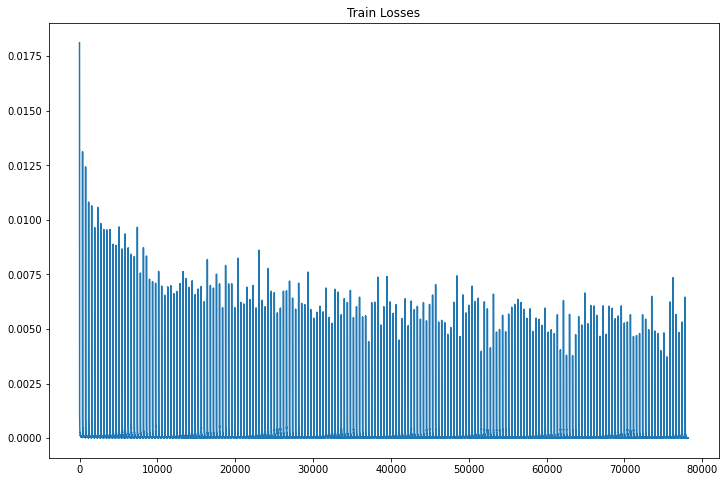

In [23]:
figure = plt.figure(figsize=(12,8))

plt.title(f"Train Losses")
plt.plot(train_stats.losses)

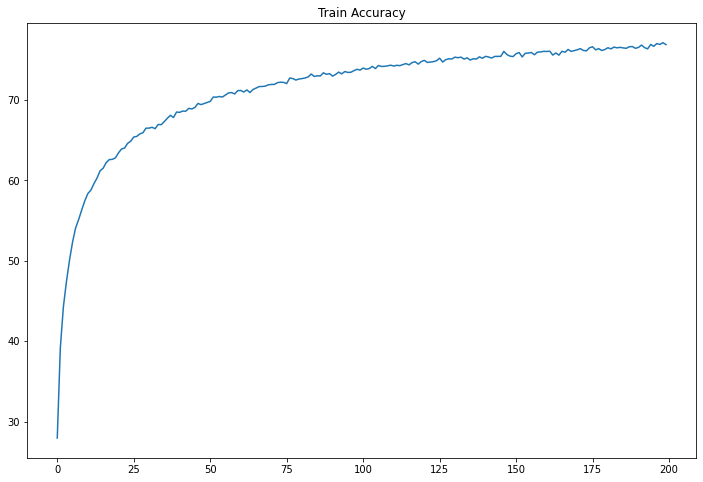

In [24]:
figure = plt.figure(figsize=(12,8))

plt.title(f"Train Accuracy")
plt.plot(train_stats.accuracy)

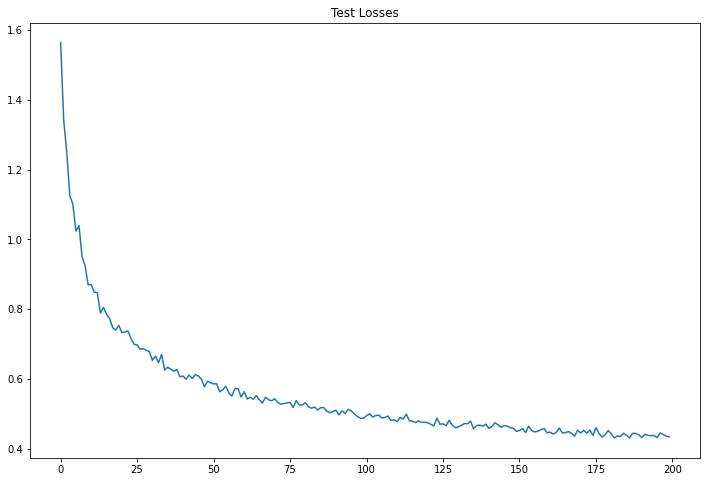

In [25]:
figure = plt.figure(figsize=(12,8))

plt.title(f"Test Losses")
plt.plot(test_stats.losses)

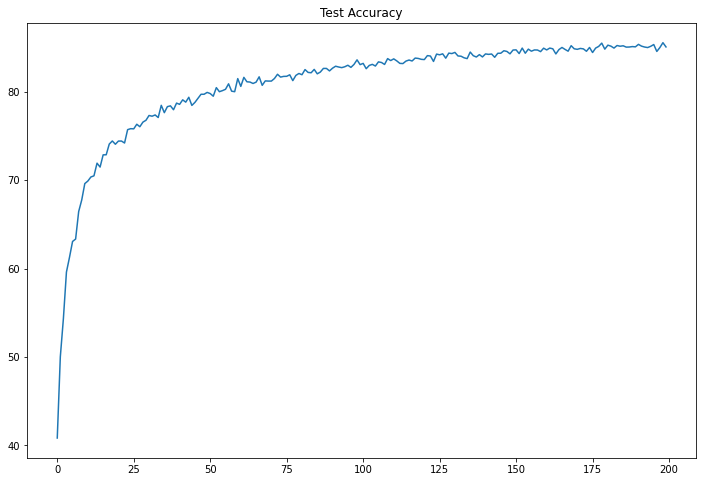

In [26]:
figure = plt.figure(figsize=(12,8))

plt.title(f"Test Accuracy")
plt.plot(test_stats.accuracy)

In [27]:
def plot_misclassified(test_stats, num_images, title, class_names, fig_size):
    
    figure=plt.figure(figsize=fig_size)
    print(f'** Plotting misclassified test images from last epoch for {title} **')
    print('\n')
    class_names_dict = class_names
    if len(test_stats.img) > num_images: 
        for i in range(num_images):
            plt.subplot(5,5,i+1)
            plt.axis(False)      
            unnorm_img = unnormalize(test_stats.img[i].cpu())
            plt.imshow(unnorm_img, interpolation='none')
            prediction = class_names_dict.get(test_stats.pred[i])
            actual     = class_names_dict.get(test_stats.label[i])
            s="pred="+str(prediction)+" act="+str(actual)
            plt.text(2,-1,s)
    else:
        print(f'Unable to plot - Less than {num_images} images, only have {len(test_stats.img)} images')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


** Plotting misclassified test images from last epoch for CIFAR-10 **




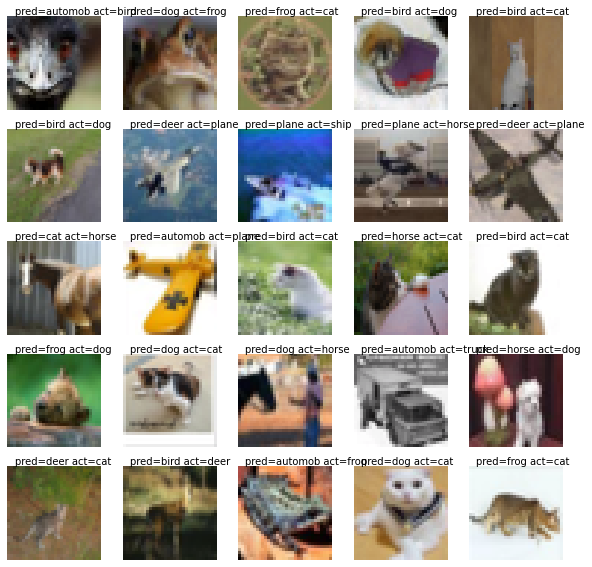

In [28]:
class_names_dict = {0:'plane', 1:'automob', 2:'bird', 3:'cat',4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
num_images       = 25
fig_size         = (10, 10)
title            = 'CIFAR-10'
misclass_stats   = test_stats
plot_misclassified(misclass_stats, num_images, title, class_names_dict, fig_size)